In [26]:
import seaborn as sns
import pandas as pd
import re
import spacy
import string
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import pickle

In [30]:
df = pd.read_csv("city_SanJose_Minutes.csv")

In [31]:
df = df.iloc[:, 1:]

<AxesSubplot:xlabel='mainID', ylabel='Count'>

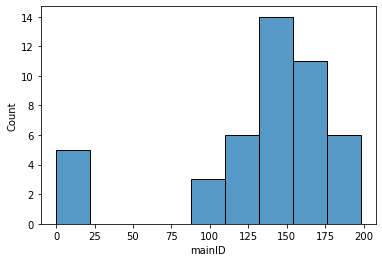

In [32]:
sns.histplot(df.groupby('artID').sum('content')['mainID'])

In [42]:
df.shape

(1576, 7)

In [53]:
art_df = pd.DataFrame(df.groupby('artID').sum('content')['subID'])

In [56]:
art_df = art_df[art_df.subID != 0]

In [64]:
df = df.merge(art_df, on='artID', how = 'inner')

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1569 entries, 0 to 1568
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   content     1569 non-null   object
 1   subID_x     1569 non-null   int64 
 2   mainID      1569 non-null   int64 
 3   artID       1569 non-null   int64 
 4   hasDollar   1569 non-null   bool  
 5   hasItem     1569 non-null   bool  
 6   hasSection  1569 non-null   bool  
 7   subID_y     1569 non-null   int64 
dtypes: bool(3), int64(4), object(1)
memory usage: 78.1+ KB


In [82]:
mainID_df = pd.DataFrame(df.groupby(by = ['mainID', 'subID_x']).sum('content'))

<AxesSubplot:xlabel='subID_x', ylabel='Count'>

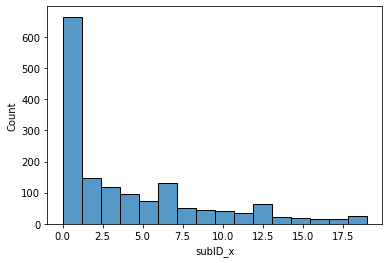

In [87]:
sns.histplot(df.subID_x)

In [98]:
for i in df[df['subID_x']!=0]['content'][2:3]:
    print(i)

2.3 Approval of Council Committee Minutes.
None provided.

City of San Jose Page 3 January 7,2020




In [100]:
df_subID = df[df['subID_x']!=0]

In [104]:
df_subID = df_subID.reset_index()
df_subID

,index,content,subID_x,mainID,artID,hasDollar,hasItem,hasSection,subID_y
0,3,2.1 Approval of City Council Minutes.None prov...,1,2,1,False,False,False,45
1,4,2.2 Final Adoption of Ordinances.20-056 Final ...,2,2,1,False,False,True,45
2,5,2.3 Approval of Council Committee Minutes.\nNo...,3,2,1,False,False,False,45
3,6,2.4 20-005 Mayor and Council Excused Absence R...,4,2,1,False,True,False,45
4,7,2.5 City Council Travel Reports.\nNone provided.,5,2,1,False,False,False,45
...,...,...,...,...,...,...,...,...,...
1126,1559,3.9 20-1635 Actions Related to Food Distributi...,9,3,45,True,True,False,269
1127,1560,3.10 20-1684 JPA-issued Bonds for Moderate-Inc...,10,3,45,False,True,False,269
1128,1561,3.11 20-1703 Fee Cap on Food Delivery Services...,11,3,45,False,True,False,269
1129,1562,3.12 20-1702 Inter-Department Transfer of Dist...,12,3,45,True,True,False,269


In [333]:
def clean_text(text):
    #text = text.decode("UTF-8")
    text = text.replace('\n'," ")
    text = text.replace('\x0c'," ")
    text = re.sub(r"-", " ", text) # Split the words with "-" (for example：pre-processing ==> pre processing）
    text = re.sub(r"\d+/\d+/\d+", "", text) # Take out the dates
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text) # Take out the time
    text = re.sub(r"[\w]+@[\.\w]+", "", text) # Take out the emails
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) # Take out the websites
    pure_text = ''
    # Validate to check if there are any non-text content 
    for letter in text:
        # Keep only letters and spaces
        if letter.isalpha() or letter==' ':
            pure_text += letter
    # Join the words are not stand-alone letters
    text = ' '.join(word for word in pure_text.split() if len(word)>1)
    return text

# Create our list of punctuation marks
punctuations = string.punctuation
# Load English tokenizer, tagger, parser, NER and word vectors
parser = spacy.load('en_core_web_sm')
# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return ' '.join(mytokens)

def nltk_stemmer(text):
    porter_stemmer = PorterStemmer()
    word_data = ' '.join(text)
    # First Word tokenization
    nltk_tokens = nltk.word_tokenize(word_data)
    #Next find the roots of the word
    t = []
    for w in nltk_tokens:       
        t.append(porter_stemmer.stem(w))
    return t

In [334]:
text = df_subID['content']

text = text.apply(lambda x: clean_text(x))

text = text.apply(lambda x: spacy_tokenizer(x))

In [329]:
t_list =[]
for i in text:
    t_list.append(clean_text(i))

In [273]:
spacy_list =[]
for i in t_list:
    spacy_list.append(spacy_tokenizer(i))

In [277]:
nltk_list =[]
for i in spacy_list:
    nltk_list.append(nltk_stemmer(i))

In [301]:
#flat_list = [item for sublist in spacy_list for item in sublist]

In [364]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.085, stop_words=ENGLISH_STOP_WORDS)

word_matrix = tfidf_vectorizer.fit_transform(text)

vocab = tfidf_vectorizer.get_feature_names()

In [365]:
vocab

['absent',
 'accept',
 'action',
 'additional',
 'administration',
 'administrative',
 'adopt',
 'agreement',
 'agreementscontracts',
 'allow',
 'amend',
 'amendment',
 'annual',
 'appropriation',
 'approval',
 'approve',
 'arenas',
 'assessment',
 'august',
 'authorize',
 'beekman',
 'blair',
 'building',
 'business',
 'california',
 'carrasco',
 'carry',
 'ceqa',
 'change',
 'chappie',
 'city',
 'citys',
 'clara',
 'code',
 'comment',
 'comments',
 'commitment',
 'committee',
 'community',
 'compensation',
 'construction',
 'contd',
 'continue',
 'contract',
 'council',
 'councilmember',
 'county',
 'covid',
 'davis',
 'december',
 'defer',
 'department',
 'deputy',
 'dev',
 'development',
 'direct',
 'director',
 'district',
 'draft',
 'emergency',
 'end',
 'enforcement',
 'environment',
 'environmental',
 'esparza',
 'event',
 'exceed',
 'execute',
 'exempt',
 'extend',
 'file',
 'final',
 'finance',
 'fiscal',
 'foley',
 'follow',
 'fund',
 'funding',
 'funds',
 'general',
 'gover

In [373]:
word_matrix.shape

(1131, 166)

In [154]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [463]:
lda_tfidf = LatentDirichletAllocation(n_components=9, random_state=0)
lda_tfidf.fit(word_matrix)

LatentDirichletAllocation(n_components=9, random_state=0)

In [464]:
pyLDAvis.sklearn.prepare(lda_tfidf, word_matrix, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.082330  0.042791       1        1  36.976544
6      0.158608 -0.014512       2        1  17.445435
3      0.134058  0.030703       3        1  11.351074
8      0.000277 -0.171495       4        1   8.797307
2      0.043571 -0.093099       5        1   7.597235
4     -0.279112  0.062579       6        1   5.884779
1     -0.255342 -0.098494       7        1   4.447253
0      0.150129 -0.003137       8        1   3.913459
5     -0.034519  0.244664       9        1   3.586913, topic_info=        Term        Freq       Total Category  logprob  loglift
130  provide  100.000000  100.000000  Default  30.0000  30.0000
138   report  107.000000  107.000000  Default  29.0000  29.0000
105  minutes   60.000000   60.000000  Default  28.0000  28.0000
44   council  125.000000  125.000000  Default  27.0000  27.0000
65     event   50.000000   50.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
146      san    3.626998   88.577127   Topic9  -3.8718   0.1324
94      josé    2.687528   78.933731   Topic9  -4.1715  -0.0521
30      city    3.409632  153.736892   Topic9  -3.9336  -0.4808
44   council    2.177549  125.197007   Topic9  -4.3820  -0.7238
165     year    1.242539   31.384793   Topic9  -4.9430   0.0987

[387 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.250759  absent
0         2  0.200608  absent
0         3  0.200608  absent
0         4  0.150456  absent
0         5  0.100304  absent
...     ...       ...     ...
164       9  0.071716    work
165       1  0.350488    year
165       2  0.318626    year
165       5  0.223038    year
165       9  0.031863    year

[657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 4, 9, 3, 5, 2, 1, 6])

In [465]:
topic_matrix = lda_tfidf.transform(word_matrix)

topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,0.037584,0.699270,0.037585,0.037584,0.037635,0.037583,0.037584,0.037586,0.037588
1,0.028495,0.028454,0.028456,0.772283,0.028455,0.028453,0.028474,0.028463,0.028467
2,0.030042,0.759653,0.030034,0.030047,0.030074,0.030036,0.030041,0.030039,0.030034
3,0.022741,0.022744,0.022747,0.022745,0.022756,0.022772,0.022757,0.022752,0.817985
4,0.037637,0.037653,0.037639,0.037637,0.698886,0.037636,0.037636,0.037637,0.037639
...,...,...,...,...,...,...,...,...,...
1126,0.017564,0.017420,0.017467,0.017443,0.017699,0.017514,0.842588,0.034818,0.017487
1127,0.017029,0.017038,0.017043,0.017032,0.017054,0.017031,0.017041,0.863688,0.017045
1128,0.016002,0.016015,0.016005,0.016005,0.016008,0.016028,0.245659,0.642258,0.016018
1129,0.015496,0.015496,0.015496,0.015499,0.015500,0.015488,0.015502,0.876016,0.015505


In [543]:
word_topic_matrix_df = pd.DataFrame(lda_tfidf.components_, columns=vocab).T.add_prefix('topic_')
word_topic_matrix_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
absent,5.181872,0.438389,2.890074,6.659691,0.176757,4.977626,0.388314
accept,6.256920,0.145770,21.275473,2.278497,3.504920,4.046185,0.143216
action,13.690499,1.656012,11.367443,12.617551,2.817550,18.408643,1.712941
additional,3.461466,0.142859,0.142955,1.047934,0.937825,6.936801,1.398887
administration,6.466205,0.142859,2.066764,3.266709,0.143004,8.060259,0.142859
administrative,15.945058,0.145643,0.142924,1.117882,0.142930,1.679234,0.142866
adopt,11.912387,0.142860,0.219651,21.804514,0.147224,32.145350,1.954869
agreement,1.371235,0.142859,0.142865,3.047422,0.142999,57.852695,0.142863
agreementscontracts,0.468789,0.142859,0.142864,0.144250,0.142873,18.311015,0.843831
allow,0.145084,0.142860,0.142905,6.449004,1.778196,4.059337,0.142860


### K-means

In [159]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity

In [160]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

In [436]:
def display_cluster(X, km=[], num_clusters=0):
    #color = 'brgcmyk'
    color = 'cmy'
    alpha = 0.5
    s = 20
    
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], c=color[0], alpha=alpha, s=s)
        
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

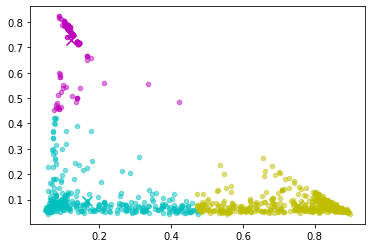

In [437]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(topic_matrix)
display_cluster(topic_matrix,km,num_clusters)

In [482]:
wcss={} # Within cluster sum of squares
for i in range(1,10):
    kmeans=KMeans(n_clusters=i, random_state=0)
    kmeans.fit(topic_matrix)
    wcss[i]=(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.
    print(f'The within cluster sum of squares for {i} clusters is {wcss[i]:.2f}') 

The within cluster sum of squares for 1 clusters is 482.77
The within cluster sum of squares for 2 clusters is 335.37
The within cluster sum of squares for 3 clusters is 250.73
The within cluster sum of squares for 4 clusters is 195.21
The within cluster sum of squares for 5 clusters is 145.25
The within cluster sum of squares for 6 clusters is 102.10
The within cluster sum of squares for 7 clusters is 76.01
The within cluster sum of squares for 8 clusters is 55.77
The within cluster sum of squares for 9 clusters is 42.20


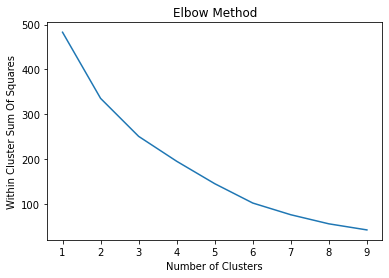

In [483]:
plt.plot(list(wcss.keys()),list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum Of Squares')
plt.show()

In [216]:
from sklearn.metrics import silhouette_score

In [484]:
s_score={} 
for i in range(2,10): # Note that the minimum number of clusters is 2
    kmeans=KMeans(n_clusters=i, random_state=0)
    kmeans.fit(topic_matrix)
    classes=kmeans.predict(topic_matrix)
    s_score[i]=(silhouette_score(topic_matrix, classes)) 
    print(f'The silhouette score for {i} clusters is {s_score[i]:.3f}') 

The silhouette score for 2 clusters is 0.352
The silhouette score for 3 clusters is 0.452
The silhouette score for 4 clusters is 0.518
The silhouette score for 5 clusters is 0.590
The silhouette score for 6 clusters is 0.656
The silhouette score for 7 clusters is 0.691
The silhouette score for 8 clusters is 0.725
The silhouette score for 9 clusters is 0.748


In [430]:
import scipy.cluster.hierarchy as hier
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

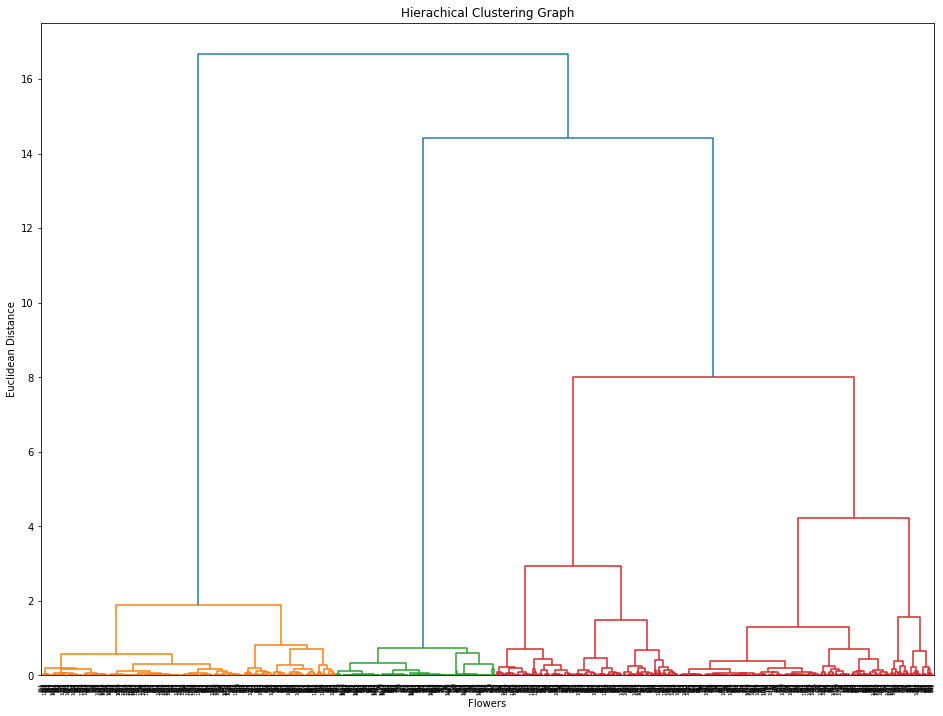

In [440]:
plt.figure(figsize=(16,12))
heirachical_graph=hier.dendrogram(hier.linkage(topic_matrix, method='ward')) #method='ward' uses the Ward variance minimization algorithm
plt.title('Hierachical Clustering Graph')
plt.xlabel('Flowers')
plt.ylabel('Euclidean Distance')
plt.show()

In [485]:
topic_matrix_df["topic"] = topic_matrix_df.iloc[:,:].idxmax(axis=1)

In [487]:
all_df = pd.concat([df_subID,topic_matrix_df], axis=1)

In [536]:
all_df

,index,content,subID_x,mainID,artID,hasDollar,hasItem,hasSection,subID_y,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic
0,3,2.1 Approval of City Council Minutes.None prov...,1,2,1,False,False,False,45,0.048355,0.709539,0.048374,0.048354,0.048558,0.048350,0.048470,topic_1
1,4,2.2 Final Adoption of Ordinances.20-056 Final ...,2,2,1,False,False,True,45,0.036673,0.036595,0.036623,0.780106,0.036597,0.036727,0.036677,topic_3
2,5,2.3 Approval of Council Committee Minutes.\nNo...,3,2,1,False,False,False,45,0.038681,0.767677,0.038668,0.038736,0.038722,0.038696,0.038819,topic_1
3,6,2.4 20-005 Mayor and Council Excused Absence R...,4,2,1,False,True,False,45,0.824019,0.029332,0.029358,0.029315,0.029344,0.029360,0.029272,topic_0
4,7,2.5 City Council Travel Reports.\nNone provided.,5,2,1,False,False,False,45,0.048419,0.048561,0.048446,0.048424,0.709228,0.048416,0.048505,topic_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,1559,3.9 20-1635 Actions Related to Food Distributi...,9,3,45,True,True,False,269,0.022475,0.022427,0.022507,0.022457,0.022565,0.864876,0.022692,topic_5
1127,1560,3.10 20-1684 JPA-issued Bonds for Moderate-Inc...,10,3,45,False,True,False,269,0.867572,0.021996,0.022027,0.021975,0.022210,0.022084,0.022136,topic_0
1128,1561,3.11 20-1703 Fee Cap on Food Delivery Services...,11,3,45,False,True,False,269,0.632834,0.020659,0.020629,0.020690,0.066310,0.218015,0.020862,topic_0
1129,1562,3.12 20-1702 Inter-Department Transfer of Dist...,12,3,45,True,True,False,269,0.878907,0.019999,0.020048,0.020874,0.020043,0.020077,0.020051,topic_0


In [480]:
for i in all_df.sort_values('topic_0', ascending = False).head(10).content:
    print(i)
    print("==============================================")

6.6 20-181 Agreement with Valley Water for the Sale of Pond A-18 for the Shoreline  
 Levee Project – Deferred. 
  Adopt a resolution authorizing the City Manager to negotiate and  

 execute an agreement with Valley Water for the sale of Pond A-18 and  

 related easements to support the Shoreline Levee Project consistent  

 with the criteria directed by the Treatment Plant Advisory Committee  

 and Council in October of 2015 and 2017. 

 CEQA: Determination of Consistency with the San Jose/Santa Clara  

 Water Pollution Control Plant Master Plan Final EIR (Resolution No.  

 76858) and all addenda thereto. File No. PP20-006. Council District 4.  

 (Environmental Services/Economic Development) 

 

Action:  Deferred to 3/3/2020 per Administration. 

 

 
 

 



 City of San José Page 18  February 25, 2020 

6.1 20-261 Agreement with Valley Water for the Sale of Pond A-18 for the Shoreline Levee Project. - DEFERRED 

Adopt a resolution authorizing the City Manager to negotiate and

In [497]:
all_df[['mainID','topic']].groupby('mainID').nunique('topic')

,topic
mainID,
1,1
2,9
3,7
4,3
5,4
6,4
7,4
8,4
9,1


In [542]:
lda_tfidf = LatentDirichletAllocation(n_components=7, random_state=0)
lda_tfidf.fit(word_matrix)
topic_matrix = lda_tfidf.transform(word_matrix)
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')
topic_matrix_df["topic"] = topic_matrix_df.iloc[:,:].idxmax(axis=1)
all_df = pd.concat([df_subID,topic_matrix_df], axis=1)
all_df[['mainID','topic']].groupby('mainID').nunique('topic')

,topic
mainID,
1,2
2,7
3,6
4,4
5,4
6,3
7,4
8,4
9,1


In [528]:
for i in range(2,11):
    lda_tfidf = LatentDirichletAllocation(n_components=i, random_state=0)
    lda_tfidf.fit(word_matrix)
    topic_matrix = lda_tfidf.transform(word_matrix)
    topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')
    topic_matrix_df["topic"] = topic_matrix_df.iloc[:,:].idxmax(axis=1)
    all_df = pd.concat([df_subID,topic_matrix_df], axis=1)
    print(i, all_df[['mainID','topic']].groupby('mainID').nunique('topic').sum()-i)
    print("===============================")

2 topic    17
dtype: int64
3 topic    17
dtype: int64
4 topic    22
dtype: int64
5 topic    22
dtype: int64
6 topic    26
dtype: int64
7 topic    30
dtype: int64
8 topic    30
dtype: int64
9 topic    30
dtype: int64
10 topic    31
dtype: int64


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



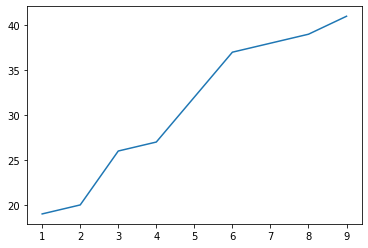

In [517]:
sns.lineplot(range(1,10),[19,20,26,27,32,37,38,39,41]);

In [220]:
import gensim
from gensim import corpora, models, similarities

In [279]:
w2v = gensim.models.Word2Vec(spacy_list, size=100, window=5, min_count=1, workers=2, sg=1)

2021-04-27 23:24:13,387 - INFO     - collecting all words and their counts
2021-04-27 23:24:13,389 - INFO     - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-27 23:24:13,421 - INFO     - collected 7363 word types from a corpus of 146919 raw words and 1131 sentences
2021-04-27 23:24:13,421 - INFO     - Loading a fresh vocabulary
2021-04-27 23:24:13,436 - INFO     - effective_min_count=1 retains 7363 unique words (100% of original 7363, drops 0)
2021-04-27 23:24:13,436 - INFO     - effective_min_count=1 leaves 146919 word corpus (100% of original 146919, drops 0)
2021-04-27 23:24:13,452 - INFO     - deleting the raw counts dictionary of 7363 items
2021-04-27 23:24:13,453 - INFO     - sample=0.001 downsamples 57 most-common words
2021-04-27 23:24:13,453 - INFO     - downsampling leaves estimated 128150 word corpus (87.2% of prior 146919)
2021-04-27 23:24:13,463 - INFO     - estimated required memory for 7363 words and 100 dimensions: 9571900 bytes
2021-04-27 23

In [280]:
list(w2v.wv.vocab.items())

[('approval', <gensim.models.keyedvectors.Vocab at 0x7fe2d90c9310>),
 ('city', <gensim.models.keyedvectors.Vocab at 0x7fe2cc5c7f70>),
 ('council', <gensim.models.keyedvectors.Vocab at 0x7fe26b158a90>),
 ('minutesnone', <gensim.models.keyedvectors.Vocab at 0x7fe26b158df0>),
 ('provide', <gensim.models.keyedvectors.Vocab at 0x7fe26b158fa0>),
 ('final', <gensim.models.keyedvectors.Vocab at 0x7fe26b158fd0>),
 ('adoption', <gensim.models.keyedvectors.Vocab at 0x7fe26b158f70>),
 ('ordinances', <gensim.models.keyedvectors.Vocab at 0x7fe26b158c70>),
 ('ord', <gensim.models.keyedvectors.Vocab at 0x7fe26b158bb0>),
 ('ordinance', <gensim.models.keyedvectors.Vocab at 0x7fe26b158dc0>),
 ('san', <gensim.models.keyedvectors.Vocab at 0x7fe26b158e80>),
 ('jose', <gensim.models.keyedvectors.Vocab at 0x7fe27837b0d0>),
 ('rezone', <gensim.models.keyedvectors.Vocab at 0x7fe27837b160>),
 ('certain', <gensim.models.keyedvectors.Vocab at 0x7fe27837b040>),
 ('real', <gensim.models.keyedvectors.Vocab at 0x7fe27

In [569]:
'action' in [i for j in spacy_list for i in j]

True

In [293]:
X = list(w2v.wv.vocab)

In [563]:
w2v.wv.most_similar(['covid','action'] ,topn=20)

[('actions', 0.8337326049804688),
 ('sheltering', 0.8117275238037109),
 ('find', 0.8074434995651245),
 ('commencement', 0.8002893924713135),
 ('preventioncontd', 0.7777178883552551),
 ('budgetary', 0.777370810508728),
 ('decline', 0.7691840529441833),
 ('impacts', 0.7663147449493408),
 ('constitute', 0.7649955749511719),
 ('shutoff', 0.7595281600952148),
 ('guidance', 0.7592676877975464),
 ('impose', 0.7575991153717041),
 ('pandemic', 0.7572484612464905),
 ('evictions', 0.7572098970413208),
 ('collective', 0.7570220232009888),
 ('following', 0.7520774602890015),
 ('deadline', 0.7490081191062927),
 ('expire', 0.7479731440544128),
 ('feedback', 0.7459443211555481),
 ('shelters', 0.7457842826843262)]

In [299]:
w2v.wv.similarity('covid','action')

0.3490647

In [565]:
word_topic_matrix_df.loc['action']

topic_0    13.690499
topic_1     1.656012
topic_2    11.367443
topic_3    12.617551
topic_4     2.817550
topic_5    18.408643
topic_6     1.712941
Name: action, dtype: float64

In [549]:
for i in all_df.sort_values('topic_4', ascending = False).head(10).content:
    print(i)
    print('===============================')

3.1 20-544 Report of the City Manager, David Sykes.  

 Recommendation: (a) City Manager’s COVID-19 Update (Verbal Report). 

 (b) City Manager’s Report on Other City Matters (Verbal Report) 

 Heard before Consent 
 

   City Manager David Sykes provided updates regarding the City’s response to  

   COVID-19. The City Manager recognized an extra-ordinary individual, Reggie Roberts,  

   from Public Works Department. Reggie has worked for the City of San Jose since 1999,  

   when he started his career in the City's warehouse and transitioned into the Mailroom. In  

   addition to always having a good attitude and great sense of humor, Reggie’s work in  

   processing and receiving the City's mail has been vital to organizational operations, in  

   terms of keeping the City functions going. Furthermore, Reggie has undertaken  

   additional duties such as taking on the bids that come in from vendors so the City can  

   accept and process those bids. 
 

   Deputy City Manager